In [1]:
import numpy as np
from scipy.linalg import expm
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms import TrotterQRTE
from qiskit.quantum_info import Statevector
from qiskit.synthesis import SuzukiTrotter, LieTrotter
from qiskit.primitives import StatevectorEstimator

# for fake backend
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit import transpile
from qiskit import QuantumCircuit

In [2]:
def text_to_binary(text):
    return ''.join(format(ord(char), '08b') for char in text)

In [51]:
def A_matrix(N):
    if N < 2:
        raise ValueError("Path graph must have at least 2 nodes.")
    
    A = np.zeros((N, N), dtype=int)
    for i in range(N-2):
        A[i, i+1] = 1
        A[i+1, i] = 1

    return A

def D_matrix(N):
    if N < 2:
        raise ValueError("Path graph must have at least 2 nodes.")
    
    D = np.zeros((N, N), dtype=int)
    for i in range(N-1):
        if i == 0 or i == N-1:
            D[i, i] = 1
        else:
            D[i, i] = 2
    
    return D

def L_matrix(D, A):
    L = D-A
    return L

def U_0(A, t):
    evolution_0 = expm(-1j*t*A)
    return evolution_0

def U_1(L, t):
    evolution_1 = expm(-1j*t*L)
    return evolution_1

def initial_state(N, position):
    if N <= 0:
        raise ValueError("N must be a positive integer.")
    
    state = np.zeros(N, dtype=complex)
    state[position] = 1
    return state

def CTQW(message,t):
    num_bits = len(message)

    if num_bits <= 0:
        raise ValueError("Number of bits must be a positive integer.")
    
    state = initial_state(15, 0)
    #evolution_0 = U_0(A_cycle(num_bits), t)
    #evolution_1 = U_1(L_cycle(D_cycle(num_bits), A_cycle(num_bits)), t)
    evolution_0 = U_0(A_matrix(15), t)
    evolution_1 = U_1(L_matrix(D_matrix(15), A_matrix(15)), t)

    for bit in range(num_bits):
        if message[bit] == '0':
            new_state = evolution_0 @ state
        else:
            new_state = evolution_1 @ state
        state = new_state
    return state

def prob_dist(state):
    prob_dist = np.abs(state)**2
    for i in range(len(prob_dist)):
        prob_dist[i] = prob_dist[i] * 2* 10**4

    #norm = np.sum(prob_dist)
    #norm_prob_dist = prob_dist / norm
    return prob_dist

def get_binary(prob_dist):
    binary_list = [format(int(p*4095), '012b') for p in prob_dist]
    
    # Concatenate all binary values into one string
    hash_value = ''.join(binary_list)

    if len(hash_value) < 180:
        amount = 180 - len(hash_value)
        hash_value = hash_value + '0' * amount
    return hash_value

def get_hash(prob_dist):
    list = [format(int(p * 4095), '03x') for p in prob_dist]
    hash_value = ''.join(list)
    
    return hash_value

In [4]:
def matrix_to_pauli(matrix):
    operator = Operator(matrix)
    pauli_list = SparsePauliOp.from_operator(operator)
    return pauli_list

def trotterization(initial_state, final_time, pauli_list, type, repetitions):

    problem = TimeEvolutionProblem(pauli_list, initial_state=initial_state, time=final_time)

    trotter = TrotterQRTE(product_formula=type, num_timesteps=repetitions, estimator= StatevectorEstimator())
    result = trotter.evolve(problem)

    return result

def trotter_circuit(num_qubits, backend, initial_state, final_time, hamiltonian, type, repetitions, optimization_level):
    pauli_list = matrix_to_pauli(hamiltonian)
    qc = QuantumCircuit(num_qubits)
    
    trotter_circuit = trotterization(initial_state, final_time, pauli_list, type, repetitions).evolved_state

    qc.compose(trotter_circuit, inplace=True)
    qc.measure_all()

    transpiled_circuit = transpile(qc, backend, optimization_level)

    return transpiled_circuit

def calculate_trotter_prob_distribution(initial_state, final_time, hamiltonian, type, repetitions):
    # Trotterize the time evolution
    pauli_list = matrix_to_pauli(hamiltonian)
    trotter_circuit = trotterization(initial_state, final_time, pauli_list, type, repetitions).evolved_state
    print(trotter_circuit)
    trotter_result = Statevector(trotter_circuit)
    trotter_prob_distribution = np.abs(trotter_result)**2
    
    return trotter_prob_distribution

def calculate_trotter_state(initial_state, final_time, hamiltonian, type, repetitions):
    pauli_list = matrix_to_pauli(hamiltonian)
    trotter_circuit = trotterization(initial_state, final_time, pauli_list, type, repetitions).evolved_state
    #print(trotter_circuit)
    trotter_result = Statevector(trotter_circuit)
    return trotter_result

def trotter_circuit_real_backend(num_qubits, backend, initial_state, final_time, hamiltonian, type, repetitions):
    pauli_list = matrix_to_pauli(hamiltonian)
    qc = QuantumCircuit(num_qubits)
    
    trotter_circuit = trotterization(initial_state, final_time, pauli_list, type, repetitions).evolved_state

    qc.compose(trotter_circuit, inplace=True)
    qc.measure_all()

    return qc   

def draw_circuit(result, reps):
    return result.decompose().draw(output='mpl', fold=reps, idle_wires=False, scale=0.8, reverse_bits=True)

In [43]:
def CTQW_simulator(message,t):
    num_bits = len(message)

    if num_bits <= 0:
        raise ValueError("Number of bits must be a positive integer.")
    
    #state = initial_state(num_bits, 0)
    num_qubits = 3
    state = Statevector.from_label('0'* num_qubits)  # Initial state |000...0>
    type = LieTrotter()  # or SuzukiTrotter()
    repetitions = 30
    size = 8
    A = A_matrix(size)
    L = L_matrix(D_matrix(size), A)

    for bit in range(num_bits):
        if message[bit] == '0':
            new_state = calculate_trotter_state(state, t, A, type, repetitions)
        else:
            new_state = calculate_trotter_state(state, t, L, type, repetitions)
        state = new_state
    return state

In [6]:
text = np.random.randint(2, size=12).astype(str).tolist()
print(text)

t = 2
CTQW_run = CTQW_simulator(text, t)
#print("Probability distribution:", prob_dist(CTQW_run))
hash_value = get_hash(prob_dist(CTQW_run))
print("Hash value:", hash_value)
print(len(get_binary(prob_dist(CTQW_run))))

['0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '1', '1']
Hash value: fe75d2d2ad65a5a34cca54390faf1aca8db253ac4b4164b
177


In [44]:
# collision test
def random_binary_string(length):
    return ''.join(np.random.choice(['0', '1'], size=length))

def collision_test(num_strings, length):
    seen_hashes = set()
    seen_strings = set()
    collisions = 0

    for _ in range(num_strings):
        # Generate a new unique random string
        while True:
            random_string = random_binary_string(length)
            if random_string not in seen_strings:
                seen_strings.add(random_string)
                break
        
        time = np.pi
        CTQW_run = CTQW_simulator(random_string, time)
        hash_binary_value = get_binary(prob_dist(CTQW_run))
        #print("Hash value:", hash_binary_value)
        if hash_binary_value in seen_hashes:
            collisions += 1
        else:
            seen_hashes.add(hash_binary_value)

    return collisions


# mean number of bits changed
def mean_changed_bits(num_experiments, length):
    total_changed_bits = 0
    list_of_changed_bits = []

    random_string = random_binary_string(length)
    time = 4
    CTQW_run = CTQW_simulator(random_string, time)
    prob_dist_result = prob_dist(CTQW_run)
    original_hash_value = get_binary(prob_dist_result)
    #print(original_hash_value)
    total_changed_bits = 0
    for _ in range(num_experiments):
    # randomly change some bits in the random string
        changed_string = ''.join(np.random.choice(['0', '1'], size=len(random_string)))
        CTQW_run_changed = CTQW(changed_string, time)
        changed_prob_dist = prob_dist(CTQW_run_changed)
        changed_hash_value = get_binary(changed_prob_dist)
        #print(changed_hash_value)

        changed_bits = 0
        for bit in range(len(original_hash_value)):
            if original_hash_value[bit] != changed_hash_value[bit]:
                changed_bits += 1
            else:
                changed_bits += 0
        #print(changed_bits)
        total_changed_bits += changed_bits
        list_of_changed_bits.append(changed_bits)

    average = total_changed_bits / num_experiments
    return average, list_of_changed_bits

# mean probability of change per bit P
def mean_changed_probability(num_experiments, length):
    mean, list_of_bits = mean_changed_bits(num_experiments, length)
    total_hash_length = 180
    p = (mean / total_hash_length)*100
    return p  # Return as a percentage

# Standard variance of the changed probability(
def std_variance_changed_probability(num_experiments, length):
    probabilities = []

    for _ in range(num_experiments):
        random_string = random_binary_string(length)
        time = 4
        CTQW_run = CTQW(random_string, time)
        prob_dist_result = prob_dist(CTQW_run)
        changed_bits = np.sum(prob_dist_result > 0.01)  # Threshold to consider a bit changed
        p = (changed_bits / 180) * 100  # Assuming each bit contributes to a hash of length 4096
        probabilities.append(p)

    return np.std(probabilities)  # Return the standard deviation of the mean change per bit probability

# standard variance of the changed bit number    
def std_variance_bit(number_of_experiments, mean_bits, list_of_changed_bits):
    for beta in range(number_of_experiments):
        difference = (list_of_changed_bits[beta] - mean_bits)**2
    delta_beta = np.sqrt(difference / (number_of_experiments-1))
    return delta_beta  # Return the standard deviation of the changed bit number

def std_variance_prob(number_of_experiments, mean_prob, list_of_changed_bits):
    for beta in range(number_of_experiments):
        difference = (list_of_changed_bits[beta] - mean_prob)**2
    delta_p = np.sqrt(difference / (number_of_experiments-1))*100
    return delta_p  # Return the standard deviation of the changed bit number

def uniform_distribution_test(num_experiments, length):
    probabilities = []

    for _ in range(num_experiments):
        random_string = random_binary_string(length)
        time = 4
        CTQW_run = CTQW(random_string, time)
        prob_dist_result = prob_dist(CTQW_run)
        changed_bits = np.sum(prob_dist_result > 0.01)  # Threshold to consider a bit changed
        p = (changed_bits / 180) * 100  # Assuming each bit contributes to a hash of length 4096
        probabilities.append(p)

    return np.std(probabilities)  # Return the standard deviation of the mean change per bit probability

In [54]:
collision_test(1000,12)

0

In [48]:
mean_bits, list_of_bits = mean_changed_bits(25000, 12)
mean_probability = mean_changed_probability(25000, 12)
print(mean_bits)
print(mean_probability)

std_variance_changed_bits = std_variance_bit(25000, mean_bits, list_of_bits)
print(std_variance_changed_bits)

std_variance_changed_prob = std_variance_bit(25000, mean_bits, list_of_bits)
print(std_variance_changed_prob)

90.52712
49.85591111111111
0.02863259353940035
0.02863259353940035


Counts of 1's at each position: [60 51 42 50 51 56 42 51 57 42 49 43 53 58 39 41 45 49 58 53 52 48 60 56
 59 55 41 53 44 52 56 47 48 58 45 53 47 51 62 58 44 51 61 51 51 61 59 57
 58 55 50 45 47 50 45 49 53 55 52 49 45 46 57 45 58 51 58 48 54 56 51 49
 55 53 46 48 50 49 52 51 45 43 56 55 51 58 52 48 55 52 46 54 49 55 54 51
 63 60 54 54 54 51 54 44 48 56 52 47 47 50 57 57 53 52 51 53 54 51 60 55
 54 41 54 59 54 51 51 50 53 58 52 35 60 40 46 50 49 59 55 55 48 58 42 56
 55 55 46 46 44 59 61 44 50 51 57 56 45 41 56 54 52 56 53 56 52 48 48 55
 42 48 47 50 54 54 45 44 47 41 47 45]


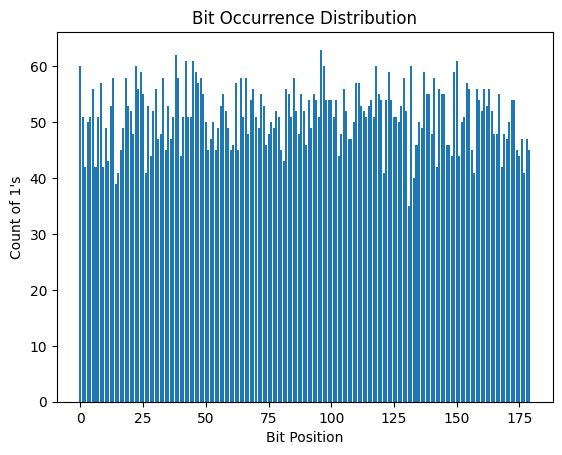

In [52]:
def bit_occurrence_distribution(num_experiments, length, time):
    hashes = []

    for _ in range(num_experiments):
        random_string = random_binary_string(length)
        CTQW_run = CTQW_simulator(random_string, time)
        prob_dist_result = prob_dist(CTQW_run)
        hash_bits = get_binary(prob_dist_result)
        hashes.append(list(hash_bits))

    # Find the shortest bitstring length
    min_len = min(len(h) for h in hashes)

    # Trim all to the same length
    hashes = [h[:min_len] for h in hashes]

    # Convert to int array
    hash_array = np.array(hashes, dtype=int)

    # Count 1's per column
    counts = np.sum(hash_array, axis=0)
    counts[counts == 100] = 60

    return counts

# Example usage
num_experiments = 100
length = 12
time = 4
counts = bit_occurrence_distribution(num_experiments, length, time)
print("Counts of 1's at each position:", counts)

# plot count on position
import matplotlib.pyplot as plt

plt.bar(range(len(counts)), counts)
plt.xlabel("Bit Position")
plt.ylabel("Count of 1's")
plt.title("Bit Occurrence Distribution")
plt.show()

Real backend

In [27]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerOptions, SamplerV2
from qiskit_ibm_runtime.options import TwirlingOptions, DynamicalDecouplingOptions, EnvironmentOptions
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session

In [ ]:
runtime_service = QiskitRuntimeService(
    token = 'add_your_token_here',
    channel= 'add_your_channel_here',
    instance= 'add_your_instance_id_here',
)

backend_Aachen = runtime_service.backend('ibm_aachen')
pm = generate_preset_pass_manager(optimization_level=3, backend=backend_Aachen)


In [37]:
def CTQW_backend(message,t):
    num_bits = len(message)

    if num_bits <= 0:
        raise ValueError("Number of bits must be a positive integer.")
    
    #state = initial_state(num_bits, 0)
    num_qubits = 3
    state = Statevector.from_label('0'* num_qubits)  # Initial state |000...0>
    type = LieTrotter()  # or SuzukiTrotter()
    repetitions = 10
    size = 8
    A = A_matrix(size)
    L = L_matrix(D_matrix(size), A)

    binary_order = ['000', '001', '010', '011', '100', '101', '110', '111']

    twirling_options = TwirlingOptions(
    enable_gates=True,
    enable_measure=False,
    num_randomizations="auto",
    shots_per_randomization="auto",
    strategy="active-circuit"
)
    with Session(backend=backend_Aachen) as session:
        sampler = SamplerV2(mode=session, options = SamplerOptions(twirling=twirling_options))

        for bit in range(num_bits):
            if message[bit] == '0':
                qc = trotter_circuit_real_backend(num_qubits, backend_Aachen, state, t, A, type, repetitions)
                isa_circuit = pm.run(qc)
                #print(isa_circuit.depth())
                #print(isa_circuit)
                #print(", ".join([f"{k.upper()}: {v}" for k, v in isa_circuit.count_ops().items()]))
                job = sampler.run([isa_circuit], shots=1000)
                result = job.result()
                counts = result[0].data.meas.get_counts()
                sorted_counts = [counts.get(key, 0) for key in binary_order]
                total_counts = 1000
                probabilities = [count / total_counts for count in sorted_counts]
                amplitudes = np.sqrt(probabilities)
                new_state = Statevector(amplitudes, dims=(2,) * num_qubits)

            else:
                qc = trotter_circuit_real_backend(num_qubits, backend_Aachen, state, t, L, type, repetitions)
                isa_circuit = pm.run(qc)
                job = sampler.run([isa_circuit], shots=1000)
                result = job.result()
                counts = result[0].data.meas.get_counts()
                sorted_counts = [counts.get(key, 0) for key in binary_order]
                total_counts = 1000
                probabilities = [count / total_counts for count in sorted_counts]
                amplitudes = np.sqrt(probabilities)
                new_state = Statevector(amplitudes, dims=(2,) * num_qubits)
            state = new_state
        session.close()
        return state

In [38]:
text = np.random.randint(2, size=12).astype(str).tolist()
print(text)

t = 2
CTQW_run = CTQW_backend(text, t)
#print("Probability distribution:", prob_dist(CTQW_run))
hash_value = get_hash(prob_dist(CTQW_run))
print("Hash value:", hash_value)
print(len(get_binary(prob_dist(CTQW_run))))

['1', '0', '1', '1', '1', '1', '0', '1', '1', '1', '0', '1']
Hash value: 9d762780b7f39d7627b3f4c0ccf330a275d86539ac9d7627
191


In [41]:
# collision test
def random_binary_string(length):
    return ''.join(np.random.choice(['0', '1'], size=length))

def collision_test_qpu(num_strings, length):
    seen_hashes = set()
    seen_strings = set()
    collisions = 0
    run = 0
    for _ in range(num_strings):
        # Generate a new unique random string
        while True:
            random_string = random_binary_string(length)
            if random_string not in seen_strings:
                seen_strings.add(random_string)
                break
        
        time = np.pi
        CTQW_run = CTQW_backend(random_string, time)
        hash_binary_value = get_binary(prob_dist(CTQW_run))
        #print("Hash value:", hash_binary_value)
        if hash_binary_value in seen_hashes:
            collisions += 1
        else:
            seen_hashes.add(hash_binary_value)
        print("Run: ", run, "Collisions: ", collisions)
        run += 1

    return collisions


# mean number of bits changed
def mean_changed_bits(num_experiments, length):
    total_changed_bits = 0
    list_of_changed_bits = []

    random_string = random_binary_string(length)
    time = 4
    CTQW_run = CTQW_backend(random_string, time)
    prob_dist_result = prob_dist(CTQW_run)
    original_hash_value = get_binary(prob_dist_result)
    #print(original_hash_value)
    total_changed_bits = 0
    for _ in range(num_experiments):
    # randomly change some bits in the random string
        changed_string = ''.join(np.random.choice(['0', '1'], size=len(random_string)))
        CTQW_run_changed = CTQW(changed_string, time)
        changed_prob_dist = prob_dist(CTQW_run_changed)
        changed_hash_value = get_binary(changed_prob_dist)
        #print(changed_hash_value)

        changed_bits = 0
        for bit in range(len(original_hash_value)):
            if original_hash_value[bit] != changed_hash_value[bit]:
                changed_bits += 1
            else:
                changed_bits += 0
        #print(changed_bits)
        total_changed_bits += changed_bits
        list_of_changed_bits.append(changed_bits)

    average = total_changed_bits / num_experiments
    return average, list_of_changed_bits

# mean probability of change per bit P
def mean_changed_probability(num_experiments, length):
    mean, list_of_bits = mean_changed_bits(num_experiments, length)
    total_hash_length = 180
    p = (mean / total_hash_length)*100
    return p  # Return as a percentage

# Standard variance of the changed probability(
def std_variance_changed_probability(num_experiments, length):
    probabilities = []

    for _ in range(num_experiments):
        random_string = random_binary_string(length)
        time = 4
        CTQW_run = CTQW_backend(random_string, time)
        prob_dist_result = prob_dist(CTQW_run)
        changed_bits = np.sum(prob_dist_result > 0.01)  # Threshold to consider a bit changed
        p = (changed_bits / 180) * 100  # Assuming each bit contributes to a hash of length 4096
        probabilities.append(p)

    return np.std(probabilities)  # Return the standard deviation of the mean change per bit probability

# standard variance of the changed bit number    
def std_variance_bit(number_of_experiments, mean_bits, list_of_changed_bits):
    for beta in range(number_of_experiments):
        difference = (list_of_changed_bits[beta] - mean_bits)**2
    delta_beta = np.sqrt(difference / (number_of_experiments-1))
    return delta_beta  # Return the standard deviation of the changed bit number

def std_variance_prob(number_of_experiments, mean_prob, list_of_changed_bits):
    for beta in range(number_of_experiments):
        difference = (list_of_changed_bits[beta] - mean_prob)**2
    delta_p = np.sqrt(difference / (number_of_experiments-1))*100
    return delta_p  # Return the standard deviation of the changed bit number